## This is Part B of our ML Project

### Part B: Decision Tree Implementation


In [89]:
import pandas as pd
import numpy as np
import torch
import random
import os
import seaborn as sns
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import warnings
import sklearn
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, GridSearchCV,train_test_split,ShuffleSplit
from matplotlib.gridspec import SubplotSpec
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,precision_recall_curve,average_precision_score,precision_score,recall_score,f1_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score,make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder,MinMaxScaler
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA
pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore')
%matplotlib inline

In [96]:
# Preprocessing
df = pd.read_csv("/Users/Xy_train.csv")
x_train = df.iloc[:,:-1]
y_train = df.iloc[:,-1]

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

l_1 = list(df["waist(cm)"])
misplaced_1 = [ind for ind,x in enumerate(l_1) if isfloat(x) == False]
# The Identified problematic rows
print(misplaced_1[0])

#Deleting rows with misplaced data ( Run only once)
try:
  df.drop([misplaced_1[0]],axis=0,inplace = True)
  print("Sample # ",misplaced_1[0] ,"was deleted")
except:
  print("Already deleted")

df["waist(cm)"] = df["waist(cm)"].astype(float)

#Identified as useless, because all of the samples are 1 and the only 12 
# different samples are misformatted
#Fixing oral values
df = df[(df["oral"] != "yes") & ((df["oral"] != "12"))]
df["oral"] = df["oral"].astype(object)
print(df["oral"].value_counts())

#Removing the row with the yes value and merging the float and the integers to one value 
df = df[df["Urine protein"] != "yes"]
df["Urine protein"] = df["Urine protein"].astype(float)
print(df["Urine protein"].value_counts())
print(pd.crosstab(df["Urine protein"],"Prior Probabity")/len(df))

df["weight(kg)"].astype(float)
df = df[df["waist(cm)"] != "ok"]
df["waist(cm)"] = df["waist(cm)"].astype(float)

#removing the null values
df.dropna(inplace = True)
#Removing all unreasonable values - removing the entire tuple if one of the values is unreasonable
# Fixing systolic values (there were negative values and values above 250)
df = df[(df["systolic"]> 0) & (df["systolic"]< 250)]
# Fixing fasting blood sugar values (there were values above 400 )
df = df[(df["fasting blood sugar"]> 0) & (df["fasting blood sugar"]< 200)]
# Fixing triglyceride values (there were values above 500 )
df = df[(df["triglyceride"]> 0) & (df["triglyceride"]< 500)]
# Fixing HDL cholesterol values (there were values above 300 )
df = df[(df["HDL"]> 10) & (df["HDL"]< 300)]
# Fixing LDL cholesterol values (there were values above 1800 )
df = df[(df["LDL"]> 0) & (df["LDL"]< 300)]
# Fixing serum creatinine values (there were values above 1.5 )
df = df[(df["serum creatinine"]> 0) & (df["serum creatinine"]< 1.5)]
# Fixing AST values (there were values above 50 )
df = df[(df["AST"]> 0) & (df["AST"]< 50)]
# Fixing ALT values (there were values above 100 )
df = df[(df["ALT"]> 0) & (df["ALT"]< 100)]
# Fixing Gtp values (there were values above 100 )
df = df[(df["Gtp"]> 0) & (df["Gtp"]< 100)]
#Deriving a new feature based on existing features
df["BMI"] = df["weight(kg)"]/((df["height(cm)"]/100)**2)


22816
Sample #  22816 was deleted
Y    44548
Name: oral, dtype: int64
1.0    42088
2.0     1431
3.0      743
4.0      202
5.0       66
6.0       10
Name: Urine protein, dtype: int64
col_0          Prior Probabity
Urine protein                 
1.0                   0.944757
2.0                   0.032122
3.0                   0.016678
4.0                   0.004534
5.0                   0.001482
6.0                   0.000224


In [97]:
df = df.iloc[:,1:]


In [100]:
df

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking,BMI
1,M,50.0,170.0,75.0,95.0,1.0,1.0,1.0,1.0,138.0,88.0,92.0,257.0,285.0,52.0,148.0,15.2,1.0,0.9,38.0,45.0,67,Y,0,Y,1,25.951557
2,M,70.0,160.0,70.0,87.8,0.6,0.6,1.0,1.0,143.0,76.0,128.0,174.0,120.0,51.0,99.0,15.8,1.0,1.0,22.0,24.0,43,Y,0,Y,1,27.343750
3,M,35.0,180.0,90.0,99.0,1.2,1.0,1.0,1.0,120.0,78.0,94.0,213.0,264.0,52.0,108.0,16.1,1.0,1.0,16.0,31.0,89,Y,0,N,1,27.777778
4,F,50.0,150.0,60.0,78.4,1.0,1.0,1.0,1.0,128.0,81.0,106.0,180.0,94.0,78.0,91.0,14.0,1.0,0.8,23.0,19.0,16,Y,0,N,1,26.666667
5,M,60.0,170.0,65.0,81.0,1.0,1.0,1.0,1.0,116.0,62.0,102.0,134.0,74.0,59.0,60.0,13.2,1.0,0.7,22.0,20.0,13,Y,1,Y,1,22.491349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44548,M,40.0,160.0,60.0,84.5,0.9,1.0,1.0,1.0,151.0,102.0,100.0,206.0,97.0,64.0,122.0,14.0,1.0,0.9,20.0,17.0,15,Y,0,N,1,23.437500
44549,M,35.0,180.0,75.0,92.0,1.0,1.2,1.0,1.0,132.0,86.0,95.0,203.0,209.0,42.0,119.0,15.9,1.0,0.9,19.0,21.0,18,Y,0,Y,0,23.148148
44550,M,20.0,175.0,60.0,76.5,0.9,0.3,1.0,1.0,99.0,50.0,91.0,162.0,64.0,54.0,95.0,15.6,1.0,1.2,18.0,13.0,18,Y,1,Y,1,19.591837
44551,M,45.0,160.0,65.0,87.2,0.5,1.0,1.0,1.0,153.0,98.0,99.0,280.0,336.0,53.0,160.0,15.9,1.0,1.3,37.0,48.0,96,Y,1,Y,1,25.390625


In [101]:

df = df.drop(['oral'],axis=1)
# dummies for gender
df['gender'].replace(['M', 'F'], [1,0], inplace=True)
# dummies for age
df['age'].replace(['Young', 'Middle', 'Old'], [2,1,0], inplace=True)
# dummies for height
df['height(cm)'].replace(['Middle', 'Tall', 'Short'], [2,1,0], inplace=True)
# dummies for weight
df['weight(kg)'].replace(['Underweight', 'Normal', 'Overweight'], [2,1,0], inplace=True)
# dummies for fasting blood sugar
df['fasting blood sugar'].replace(['Pre-Diabetes', 'Diabetes', 'Normal'], [2,1,0], inplace=True)
# dummies for tartar
df['tartar'].replace(['Y', 'N'], [1,0], inplace=True)


In [102]:
df

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar,smoking,BMI
1,1,50.0,170.0,75.0,95.0,1.0,1.0,1.0,1.0,138.0,88.0,92.0,257.0,285.0,52.0,148.0,15.2,1.0,0.9,38.0,45.0,67,0,1,1,25.951557
2,1,70.0,160.0,70.0,87.8,0.6,0.6,1.0,1.0,143.0,76.0,128.0,174.0,120.0,51.0,99.0,15.8,1.0,1.0,22.0,24.0,43,0,1,1,27.343750
3,1,35.0,180.0,90.0,99.0,1.2,1.0,1.0,1.0,120.0,78.0,94.0,213.0,264.0,52.0,108.0,16.1,1.0,1.0,16.0,31.0,89,0,0,1,27.777778
4,0,50.0,150.0,60.0,78.4,1.0,1.0,1.0,1.0,128.0,81.0,106.0,180.0,94.0,78.0,91.0,14.0,1.0,0.8,23.0,19.0,16,0,0,1,26.666667
5,1,60.0,170.0,65.0,81.0,1.0,1.0,1.0,1.0,116.0,62.0,102.0,134.0,74.0,59.0,60.0,13.2,1.0,0.7,22.0,20.0,13,1,1,1,22.491349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44548,1,40.0,160.0,60.0,84.5,0.9,1.0,1.0,1.0,151.0,102.0,100.0,206.0,97.0,64.0,122.0,14.0,1.0,0.9,20.0,17.0,15,0,0,1,23.437500
44549,1,35.0,180.0,75.0,92.0,1.0,1.2,1.0,1.0,132.0,86.0,95.0,203.0,209.0,42.0,119.0,15.9,1.0,0.9,19.0,21.0,18,0,1,0,23.148148
44550,1,20.0,175.0,60.0,76.5,0.9,0.3,1.0,1.0,99.0,50.0,91.0,162.0,64.0,54.0,95.0,15.6,1.0,1.2,18.0,13.0,18,1,1,1,19.591837
44551,1,45.0,160.0,65.0,87.2,0.5,1.0,1.0,1.0,153.0,98.0,99.0,280.0,336.0,53.0,160.0,15.9,1.0,1.3,37.0,48.0,96,1,1,1,25.390625


In [103]:

# Splitting the data into train and test
train_df,val_df = train_test_split(df,test_size=0.2,random_state=42)

# Splitting the data into train and validation sets
y_train = train_df['smoking'].copy()
y_train.reset_index(drop=True,inplace=True)

X_train = train_df.drop('smoking',axis=1).copy()
X_train.reset_index(drop=True,inplace=True)

y_val = val_df['smoking'].copy()
y_val.reset_index(drop=True,inplace=True)

X_val = val_df.drop('smoking',axis=1).copy()
X_val.reset_index(drop=True,inplace=True)


Series([], dtype: float64)

In [105]:
X_train.head()

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar,BMI
0,0,40.0,150.0,55.0,75.0,1.5,1.2,1.0,1.0,120.0,80.0,76.0,211.0,142.0,65.0,117.0,13.1,1.0,0.8,17.0,15.0,12,0,0,24.444444
1,1,60.0,160.0,65.0,89.0,1.2,1.5,1.0,2.0,118.0,83.0,92.0,180.0,248.0,43.0,87.0,14.6,1.0,1.2,32.0,32.0,51,0,0,25.390625
2,1,25.0,175.0,80.0,91.8,1.2,1.5,1.0,1.0,147.0,87.0,171.0,220.0,252.0,34.0,136.0,15.9,1.0,1.0,27.0,39.0,45,0,1,26.122449
3,1,25.0,170.0,60.0,73.0,1.2,0.8,1.0,1.0,116.0,67.0,98.0,173.0,47.0,56.0,108.0,15.6,1.0,1.0,18.0,15.0,13,0,0,20.761246
4,1,25.0,175.0,80.0,83.5,1.2,1.2,1.0,1.0,129.0,73.0,88.0,213.0,82.0,72.0,124.0,15.3,1.0,0.9,22.0,13.0,16,0,0,26.122449


In [106]:
#Simple decision tree classifier
dt = DecisionTreeClassifier(random_state=42,max_depth=3,min_samples_leaf=5,min_samples_split=5,max_features=0.5)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_val)
print("Test Accuracy score: ",accuracy_score(y_val,y_pred))
print("Train accuracy score: ",accuracy_score(y_train,dt.predict(X_train)))

Test Accuracy score:  0.727930174563591
Train accuracy score:  0.7282703578999875


<AxesSubplot: >

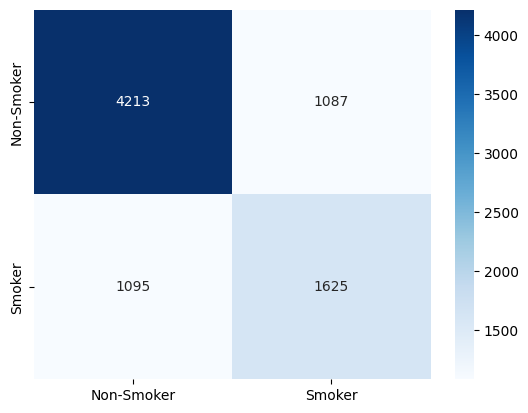

In [107]:
#Confusion matrix for the decision tree classifier
cm = confusion_matrix(y_val,y_pred)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=['Non-Smoker','Smoker'],yticklabels=['Non-Smoker','Smoker'])

[Text(0.5, 0.875, 'hemoglobin <= 14.45\ngini = 0.452\nsamples = 32076\nvalue = [20991, 11085]'),
 Text(0.25, 0.625, 'height(cm) <= 167.5\n0.233\n14123\n[12223, 1900]'),
 Text(0.125, 0.375, 'Gtp <= 23.5\n0.152\n12242\n[11230, 1012]'),
 Text(0.0625, 0.125, '0.098\n8830\n[8372, 458]'),
 Text(0.1875, 0.125, '0.272\n3412\n[2858, 554]'),
 Text(0.375, 0.375, 'gender <= 0.5\n0.498\n1881\n[993, 888]'),
 Text(0.3125, 0.125, '0.095\n220\n[209, 11]'),
 Text(0.4375, 0.125, '0.498\n1661\n[784, 877]'),
 Text(0.75, 0.625, 'Gtp <= 28.5\n0.5\n17953\n[8768, 9185]'),
 Text(0.625, 0.375, 'height(cm) <= 162.5\n0.483\n8558\n[5076, 3482]'),
 Text(0.5625, 0.125, '0.332\n1575\n[1244, 331]'),
 Text(0.6875, 0.125, '0.495\n6983\n[3832, 3151]'),
 Text(0.875, 0.375, 'gender <= 0.5\n0.477\n9395\n[3692, 5703]'),
 Text(0.8125, 0.125, '0.194\n339\n[302, 37]'),
 Text(0.9375, 0.125, '0.468\n9056\n[3390, 5666]')]

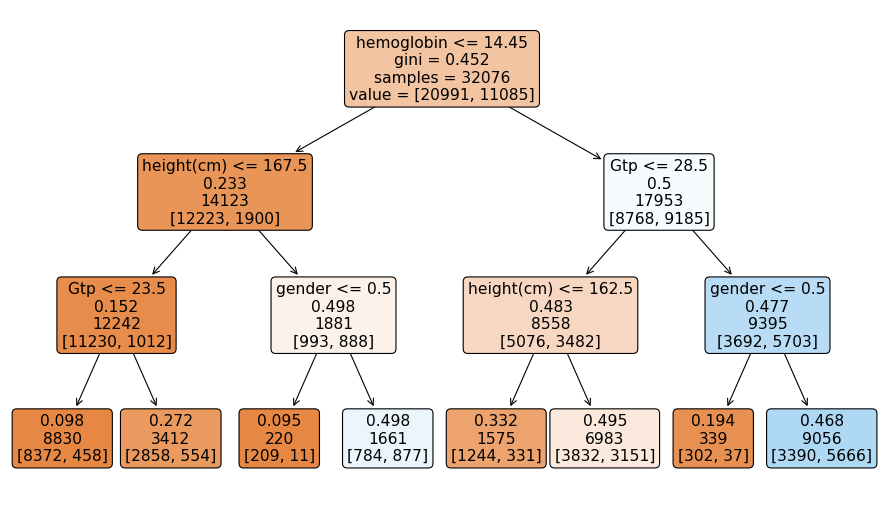

In [108]:
plt.figure(figsize=(14,8),dpi = 80)
tree.plot_tree(dt,label="root",feature_names=X_train.columns,filled=True,rounded=True,fontsize=14)

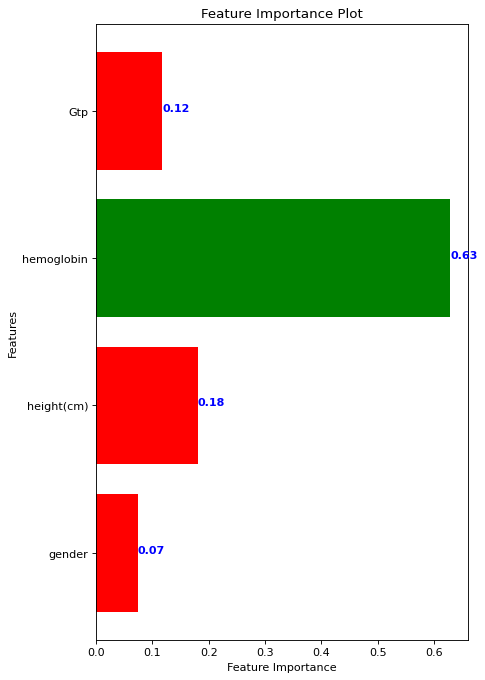

In [110]:

##########
#Extract feature importance from decision tree classifier and show only features with importance > 0.2
feature_importance = dt.feature_importances_
#Plot the feature importance with colors according to the importance
plt.figure(figsize=(6,10),dpi = 80)
#Removing the features with importance < 0.2
relevant_columns = X_train.columns[feature_importance >= 0.01]
feature_importance = feature_importance[feature_importance >= 0.01]
plt.barh(relevant_columns,feature_importance,color=['red' if x < 0.2 else 'green' for x in feature_importance])
#plot the actual feature importance values
for i, v in enumerate(feature_importance):
    plt.text(v, i, str(round(v,2)), color='blue', fontweight='bold')
    
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Plot")
plt.show()

In [111]:
#Running Grid Search Cross Validation for hyperparameter tuning
param_grid = {'max_depth': [3,5,7,10],
                'min_samples_split': [500,1000,1500],
                'min_samples_leaf': [500,1000,1500],
                'max_features': [5,10,20,40],
                'criterion': ['gini', 'entropy',"log_loss"],
                'splitter': ['best'],
                'class_weight': ['balanced']}
             
                
grid_search_2 = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring="accuracy", return_train_score=True,verbose=3 , error_score='raise')
grid_search_2.fit(X_train, y_train)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=5, min_samples_leaf=500, min_samples_split=500, splitter=best;, score=(train=0.680, test=0.678) total time=   0.0s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=5, min_samples_leaf=500, min_samples_split=500, splitter=best;, score=(train=0.710, test=0.719) total time=   0.0s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=5, min_samples_leaf=500, min_samples_split=500, splitter=best;, score=(train=0.703, test=0.693) total time=   0.0s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=5, min_samples_leaf=500, min_samples_split=500, splitter=best;, score=(train=0.629, test=0.622) total time=   0.0s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=3, max_features=5, min_samples_leaf=500, min_samples_split=500, splitter=best;, score=(train=0.672, te

GridSearchCV(cv=5, error_score='raise', estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 7, 10],
                         'max_features': [5, 10, 20, 40],
                         'min_samples_leaf': [500, 1000, 1500],
                         'min_samples_split': [500, 1000, 1500],
                         'splitter': ['best']},
             return_train_score=True, scoring='accuracy', verbose=3)

In [112]:
parameters = pd.DataFrame(grid_search_2.cv_results_["params"])
train_scores = pd.DataFrame(grid_search_2.cv_results_["mean_train_score"])
test_scores = pd.DataFrame(grid_search_2.cv_results_["mean_test_score"])
cv_results = pd.concat([parameters,train_scores,test_scores],axis=1)
cv_results.columns.values[-2:] = ["Train Accuracy Score","Test Accuracy Score"]
cv_results.sort_values(by="Test Accuracy Score",ascending=False,inplace=True)

In [113]:
cv_results.head(10).style.background_gradient(cmap='Blues')

,class_weight,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,splitter,Train Accuracy Score,Test Accuracy Score
129,balanced,gini,10,20,1000,500,best,0.722627,0.721256
203,balanced,entropy,5,20,1000,1500,best,0.720866,0.719572
381,balanced,log_loss,7,20,1000,500,best,0.720461,0.719479
379,balanced,log_loss,7,20,500,1000,best,0.721069,0.719198
416,balanced,log_loss,10,20,500,1500,best,0.721934,0.719011
128,balanced,gini,10,20,500,1500,best,0.720796,0.718699
102,balanced,gini,7,40,1000,500,best,0.720804,0.718668
248,balanced,entropy,7,40,1000,1500,best,0.720804,0.718668
390,balanced,log_loss,7,40,1000,500,best,0.720804,0.718668
356,balanced,log_loss,5,40,1000,1500,best,0.720804,0.718668


0.7143658810325477

0.7138403990024937

<AxesSubplot: >

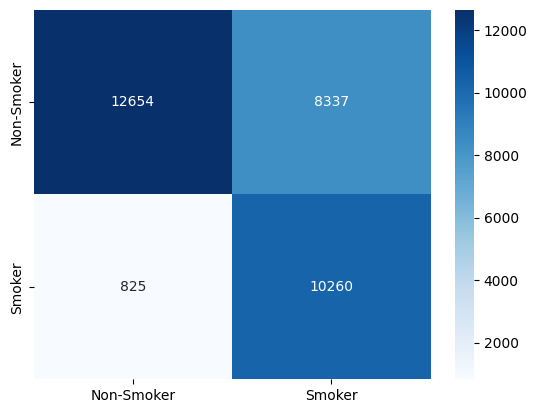

In [114]:
classifier_2 = grid_search_2.best_estimator_
display(accuracy_score(y_train,classifier_2.predict(X_train)))
display(accuracy_score(y_val,classifier_2.predict(X_val)))
sns.heatmap(confusion_matrix(y_train,classifier_2.predict(X_train)),annot=True,fmt='d',cmap='Blues',xticklabels=['Non-Smoker','Smoker'],yticklabels=['Non-Smoker','Smoker'])

0.7138403990024937

<AxesSubplot: >

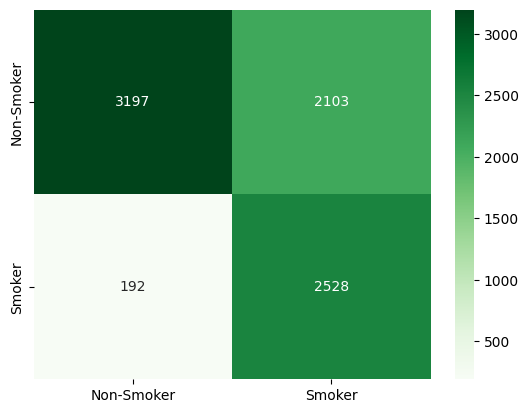

In [115]:
display(accuracy_score(y_val,classifier_2.predict(X_val)))
sns.heatmap(confusion_matrix(y_val,classifier_2.predict(X_val)),annot=True,fmt='d',cmap='Greens',xticklabels=['Non-Smoker','Smoker'],yticklabels=['Non-Smoker','Smoker'])

In [116]:
grid_search_2.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 20,
 'min_samples_leaf': 1000,
 'min_samples_split': 500,
 'splitter': 'best'}

[Text(0.47115384615384615, 0.9, 'gender <= 0.5\ngini = 0.5\nsamples = 32076\nvalue = [16038.0, 16038.0]'),
 Text(0.25, 0.7, 'Gtp <= 23.5\n0.139\n12416\n[9095.153, 740.772]'),
 Text(0.15384615384615385, 0.5, 'Gtp <= 15.5\n0.104\n9182\n[6806.084, 396.429]'),
 Text(0.07692307692307693, 0.3, 'AST <= 18.5\n0.075\n5057\n[3782.771, 153.363]'),
 Text(0.038461538461538464, 0.1, '\n  (...)  \n'),
 Text(0.11538461538461539, 0.1, '\n  (...)  \n'),
 Text(0.23076923076923078, 0.3, 'ALT <= 14.5\n0.138\n4125\n[3023.313, 243.066]'),
 Text(0.19230769230769232, 0.1, '\n  (...)  \n'),
 Text(0.2692307692307692, 0.1, '\n  (...)  \n'),
 Text(0.34615384615384615, 0.5, 'age <= 47.5\n0.227\n3234\n[2289.069, 344.343]'),
 Text(0.3076923076923077, 0.3, '0.297\n1420\n[971.097, 215.576]'),
 Text(0.38461538461538464, 0.3, '0.162\n1814\n[1317.972, 128.767]'),
 Text(0.6923076923076923, 0.7, 'Gtp <= 28.5\n0.429\n19660\n[6942.847, 15297.228]'),
 Text(0.5384615384615384, 0.5, 'triglyceride <= 88.5\n0.477\n9352\n[3925.646,

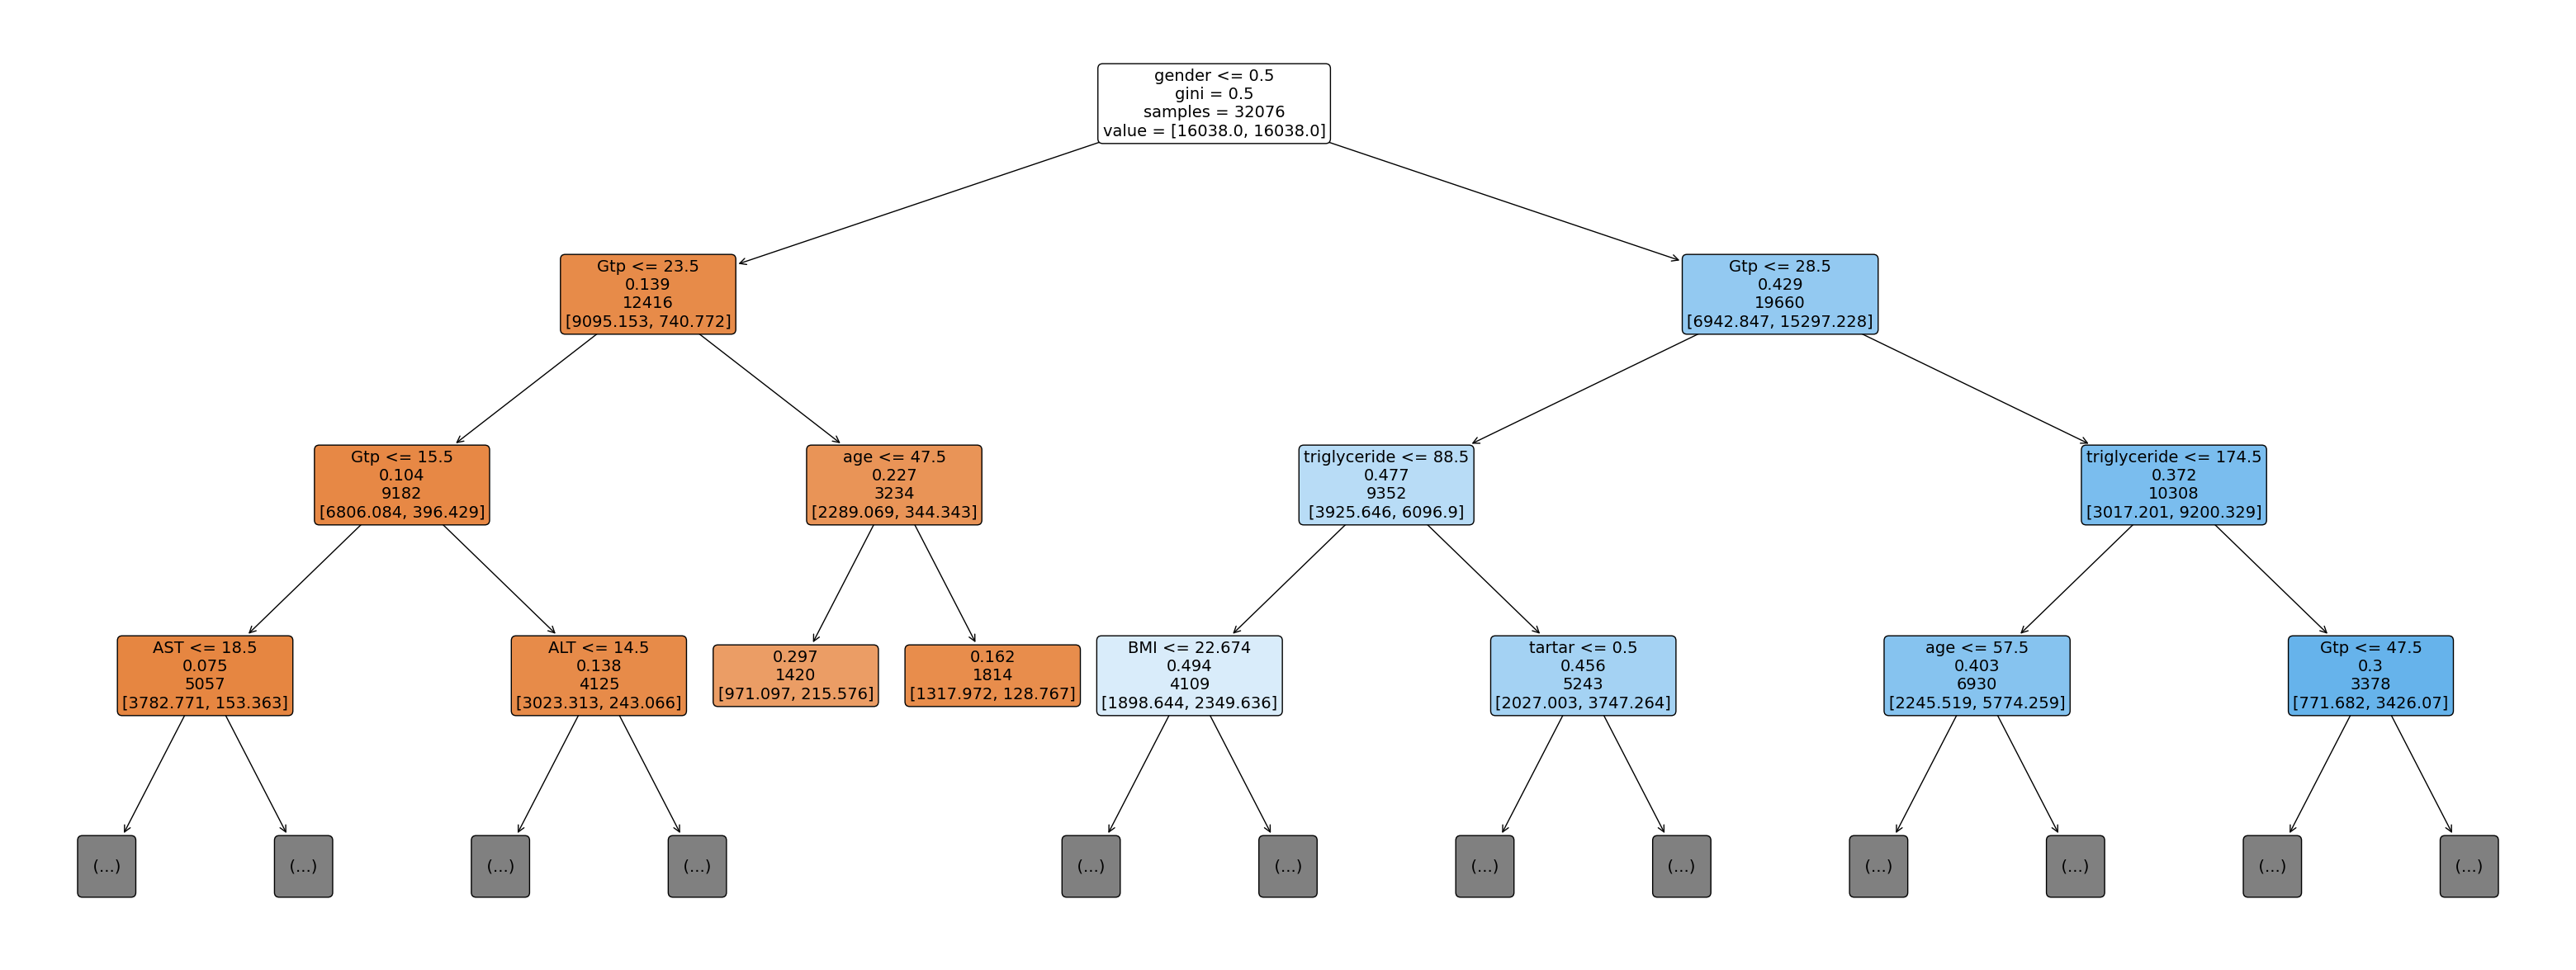

In [117]:
plt.figure(figsize=(40,15),dpi = 100)
tree.plot_tree(classifier_2,max_depth = 3 ,label="root",filled=True,rounded=True,fontsize=14,feature_names = X_train.columns)

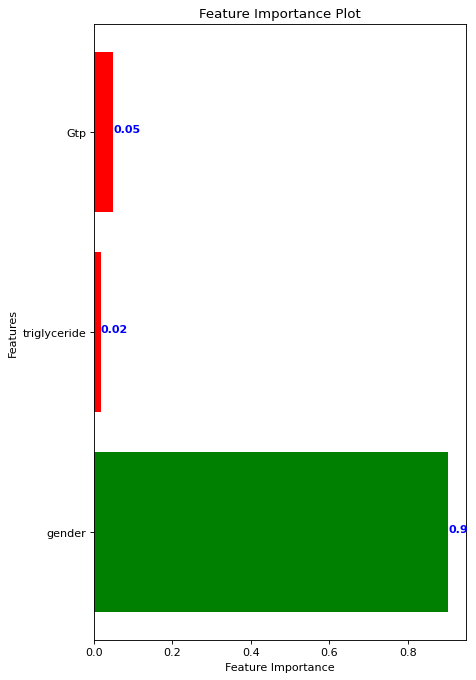

In [118]:
#Extract feature importance from decision tree classifier and show only features with importance > 0.2
feature_importance = classifier_2.feature_importances_
#Plot the feature importance with colors according to the importance
plt.figure(figsize=(6,10),dpi = 80)
#Removing the features with importance < 0.2
relevant_columns = X_train.columns[feature_importance >= 0.01]
feature_importance = feature_importance[feature_importance >= 0.01]
plt.barh(relevant_columns,feature_importance,color=['red' if x < 0.2 else 'green' for x in feature_importance])
#plot the actual feature importance values
for i, v in enumerate(feature_importance):
    plt.text(v, i, str(round(v,2)), color='blue', fontweight='bold')
    
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Plot")
plt.show()

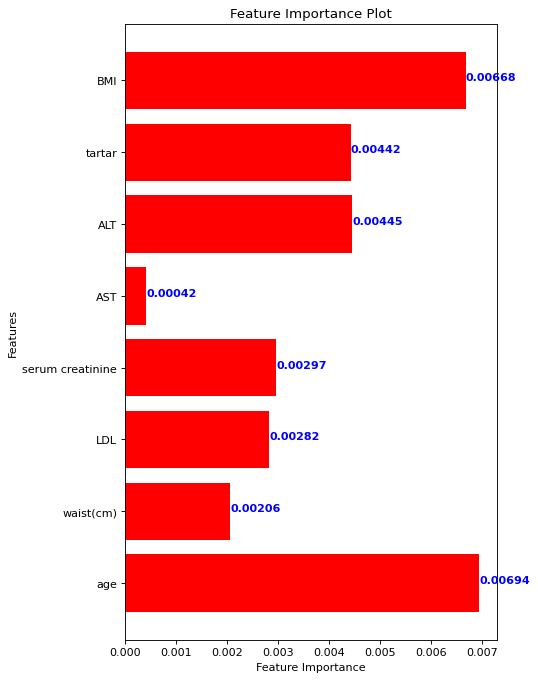

In [119]:
#Extract feature importance from decision tree classifier and show only features with importance > 0.2
feature_importance = classifier_2.feature_importances_
#Plot the feature importance with colors according to the importance
plt.figure(figsize=(6,10),dpi = 80)
#Removing the features with importance < 0.2
relevant_columns = X_train.columns[(feature_importance <= 0.01) & (feature_importance > 0)]
feature_importance = feature_importance[(feature_importance <= 0.01) & (feature_importance >0) ]
plt.barh(relevant_columns,feature_importance,color=['red' if x < 0.2 else 'green' for x in feature_importance])
#plot the actual feature importance values
for i, v in enumerate(feature_importance):
    plt.text(v, i, str(round(v,5)), color='blue', fontweight='bold')
    
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Plot")
plt.show()

In [120]:
#Predicting on sample 15 from the validation set
print("Predicted Value : " , classifier_2.predict(X_val.iloc[15].values.reshape(1,-1)))
#Actual value of sample 15 from the validation set
print("Ground Truth : ", y_val.iloc[15])



Predicted Value :  [0]
Ground Truth :  0


# Creating The NN

In [121]:
standard_scaler = StandardScaler() # new_value = (prev_value - mean(prev_value)) / SD(prev_value) --> Z distribution
X_train_s = standard_scaler.fit_transform(X_train)
X_valid_s = standard_scaler.fit_transform(X_val)

## Mission 1 - Create MLP with default value

MLP-default accuracy on train: 81.762 %
MLP-default accuracy on test: 76.122 %


Text(0.5, 1.0, 'Loss function')

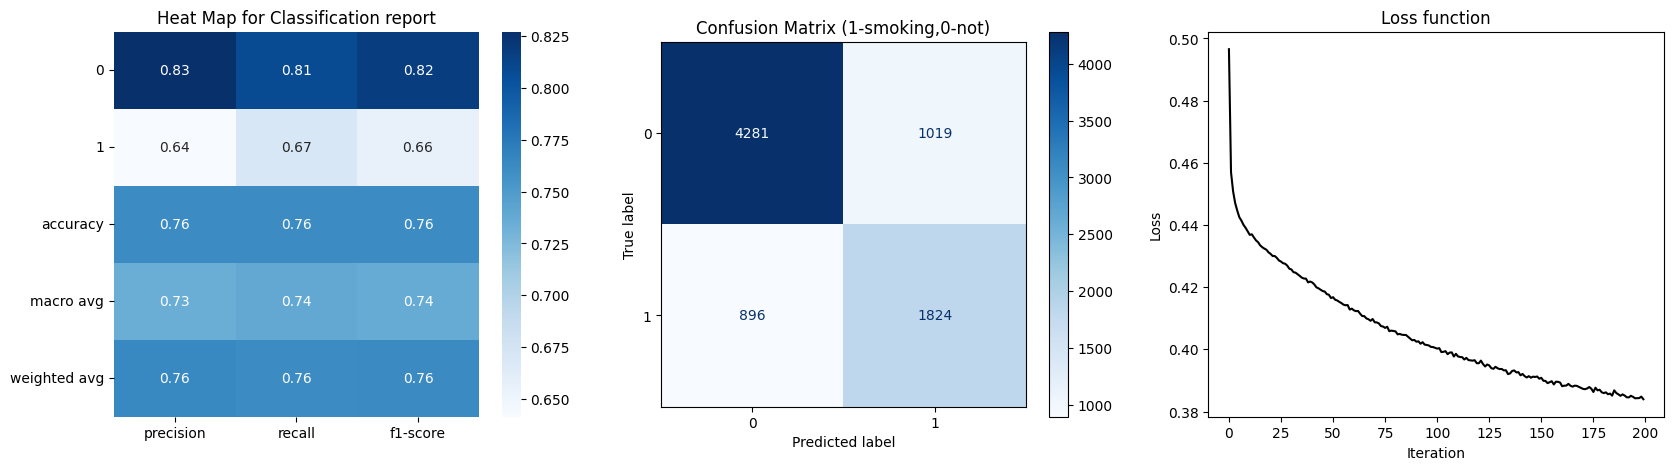

In [122]:
model = MLPClassifier()
model.fit(X_train_s, y_train)
print(f'MLP-default accuracy on train: {round(model.score(X_train_s, y_train)*100,3)} %')
pred_y = model.predict(X_valid_s)
NN_report = classification_report(y_val,pred_y, output_dict=True)
# Model Accuracy, how often is the classifier correct
print(f'MLP-default accuracy on test: {round(accuracy_score(y_val,pred_y)*100,3)} %')

fig, ax = plt.subplots((1),(3),figsize = (20,5))
#plot 1
sns.heatmap(pd.DataFrame(NN_report).iloc[:-1, :].T, annot=True, cmap = "Blues", ax = ax[0])
ax[0].set_title('Heat Map for Classification report')
#plot 2
cm = confusion_matrix(y_val,pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues", ax=ax[1])
ax[1].set_title('Confusion Matrix (1-smoking,0-not)')
#plot 3
ax[2].plot(model.loss_curve_, color = "Black")
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("Loss")
ax[2].set_title('Loss function')

**The conclusions that can be drawn from the graphs shown:**

    1) From the loss function you can see that the loss continues to decrease even after 200 iterations,
       therefore we will want a relatively high number in limiting the number of iterations later.
    2) The model convergence in the default mode happens relatively slowly.
    3) The model classifies in a significantly better way the examples of non-smokers.


## Mission 2 - Tuning the Model

In [123]:
#First try tuning with 3 layer (size,size,2)
train_accs = []
test_accs = []
for size_ in range(1, 30, 2):
    model = MLPClassifier(random_state=1,
                        hidden_layer_sizes=(size_, size_, 2),
                        max_iter=200, # from the graphs shown 
                        activation='logistic', # for binary classification
                        verbose=False,
                        learning_rate_init=0.001,
                        alpha=0.00)
    model.fit(X_train_s, y_train)
    train_acc = model.score(X_train_s, y_train)
    train_accs.append(train_acc)
    test_acc = model.score(X_valid_s, y_val)
    test_accs.append(test_acc)

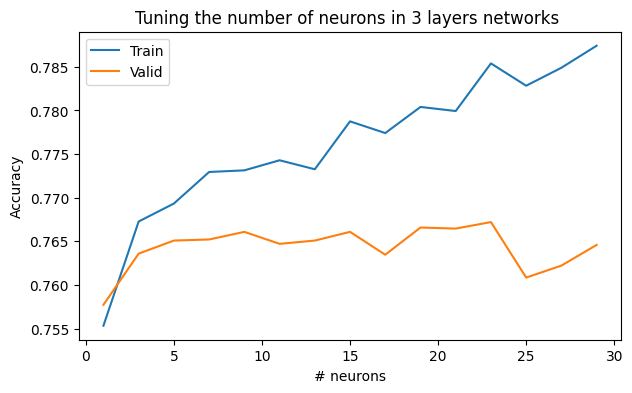

Max accuracy on train: 0.7874111485222597 
Max accuracy on valid: 0.767206982543641


In [124]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, 30, 2), train_accs, label='Train')
plt.plot(range(1, 30, 2), test_accs, label='Valid')
plt.legend()
plt.xlabel('# neurons')
plt.ylabel('Accuracy')
plt.title('Tuning the number of neurons in 3 layers networks ')
plt.show()
print(f"Max accuracy on train: {max(train_accs)} \nMax accuracy on valid: {max(test_accs)}")

2nd try tuning with more attributes in Grid Search:

    1) 3 types of 4 layers
    2) 3 activation function
    3) 2 solver
    4) 3 values of learning rate init
    5) 3 values of alpha

In [36]:
param_grid = {
    'hidden_layer_sizes': [(5,10,10,10),(5,10,15,20),(5,10,20,30)], 
    'activation': ['logistic', 'relu', 'tanh'],
    'solver': ['sgd', 'adam'],
    'learning_rate_init': [0.001,0.005,0.01],
    'learning_rate': ['constant'],
    'alpha': [0.0001,0.001,0.0005]
}

grid_search = GridSearchCV(MLPClassifier(), param_grid, 
                           scoring=['f1', 'accuracy'], refit='accuracy', verbose=2)
grid_search.fit(X_train_s, y_train)
print(f'Score: {grid_search.best_score_}')
print(f'Parameters: {grid_search.best_params_}')

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10, 10, 10), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10, 10, 10), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.6s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10, 10, 10), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.6s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10, 10, 10), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10, 10, 10), learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 10, 10, 10), learning_rate=constant, learning_rate_init=0.001, so

As we can see after tunings, we will choose activation = 'relu', alpha = 0.0005, learning rate init = 0.005, solver = 'sgd'
now we will try to use only columns with high correltion with target

In [131]:
temp_df = pd.concat((X_train, y_train),axis = 1)
df_corr = temp_df.corr().loc[:,["smoking"]]
new_corr = pd.DataFrame(df_corr['smoking'].between(left=0.09, right=0.9))
new_corr['smoking1'] = pd.DataFrame(df_corr['smoking'].between(left=-0.9, right=-0.09))
# create list for new df
list_for_remove = []
for d,r in new_corr.iterrows():
    if r[0] == False and r[1] == False:
        list_for_remove.append(d)
list_for_remove.remove('smoking')
# remove columns with minimum correlation and create new data set
df_new = temp_df.copy()   
df_new = df_new.drop(columns=list_for_remove)
df_new.head()



,gender,age,height(cm),weight(kg),waist(cm),triglyceride,HDL,hemoglobin,serum creatinine,ALT,Gtp,dental caries,tartar,BMI,smoking
0,0,40.0,150.0,55.0,75.0,142.0,65.0,13.1,0.8,15.0,12,0,0,24.444444,0
1,1,60.0,160.0,65.0,89.0,248.0,43.0,14.6,1.2,32.0,51,0,0,25.390625,0
2,1,25.0,175.0,80.0,91.8,252.0,34.0,15.9,1.0,39.0,45,0,1,26.122449,0
3,1,25.0,170.0,60.0,73.0,47.0,56.0,15.6,1.0,15.0,13,0,0,20.761246,0
4,1,25.0,175.0,80.0,83.5,82.0,72.0,15.3,0.9,13.0,16,0,0,26.122449,0


In [225]:
wanted = df_new.columns

In [133]:
# Pruned Data
X_train_new = df_new.drop(columns=['smoking'])
y_train_new = df_new['smoking']
# Split the data into train and validation
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_train_new, y_train_new, test_size=0.2, random_state=1)
X_train_new_s = standard_scaler.fit_transform(X_train_new)
X_valid_new_s = standard_scaler.fit_transform(X_val_new)

In [136]:
train_accs = []
test_accs = []
for size_ in range(1, 30, 4):
    print(f"size: {size_}")
    model = MLPClassifier(random_state=1,
                        hidden_layer_sizes=(size_, size_, size_,2),
                        max_iter=400, # from the graphs shown 
                        activation='relu', 
                        verbose=False,
                        solver='sgd',
                        alpha=0.0005,
                        learning_rate_init=0.005)
    model.fit(X_train_new_s, y_train_new)
    train_acc = model.score(X_train_new_s, y_train_new)
    train_accs.append(train_acc)
    test_acc = model.score(X_valid_new_s, y_val_new)
    test_accs.append(test_acc)

size: 1
size: 5
size: 9
size: 13
size: 17
size: 21
size: 25
size: 29


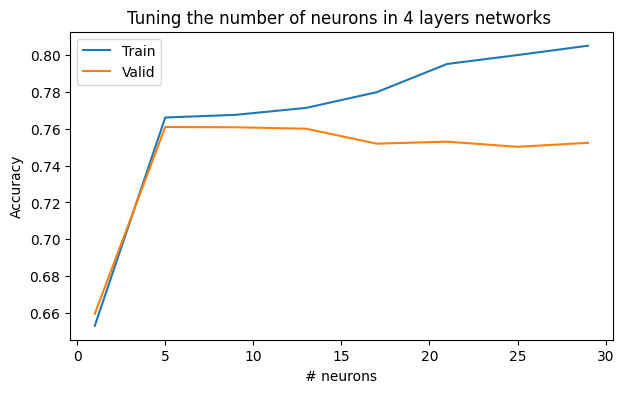

Max accuracy on train: 0.8049883086515979 
Max accuracy on valid: 0.7609102244389028


In [137]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, 30, 4), train_accs, label='Train')
plt.plot(range(1, 30, 4), test_accs, label='Valid')
plt.legend()
plt.xlabel('# neurons')
plt.ylabel('Accuracy')
plt.title('Tuning the number of neurons in 4 layers networks ')
plt.show()
print(f"Max accuracy on train: {max(train_accs)} \nMax accuracy on valid: {max(test_accs)}")

In [ ]:
X_val

In [157]:
# Transforming to Tensors 
x_train_tensor = torch.tensor(X_train_new_s, dtype=torch.float)
y_train_tensor = torch.tensor(y_train_new.values, dtype=torch.float)
x_test_tensor = torch.tensor(X_valid_new_s, dtype=torch.float)
y_test_tensor = torch.tensor(y_val_new.values, dtype=torch.float)


In [158]:

non_smoking_weigth = torch.tensor((df['smoking'].value_counts()[0] / len(df)),dtype=torch.float)
smoking_weigth = torch.tensor((df['smoking'].value_counts()[1] / len(df)),dtype=torch.float)
# Define the weights for each sample
weights = torch.tensor([non_smoking_weigth, smoking_weigth]) # Class 0 has weight ~65%, class 1 has weight ~35%


In [159]:
weights

tensor([0.6557, 0.3443])

In [160]:
x_train_tensor.shape

torch.Size([25660, 14])

In [161]:
# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, middle_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, middle_size)
        self.relu = nn.ReLU()
        self.drop1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(middle_size, hidden_size)
        self.drop2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.drop1(out)
        out = self.fc2(out)
        out = self.drop1(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

model = MLP(14, 128, 64, 2)

In [162]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Train the model
for epoch in range(500):
    # Forward pass
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor.long())
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/500], Loss: {loss.item():.4f}')

Epoch [50/500], Loss: 0.3846
Epoch [100/500], Loss: 0.3801
Epoch [150/500], Loss: 0.3785
Epoch [200/500], Loss: 0.3770
Epoch [250/500], Loss: 0.3760
Epoch [300/500], Loss: 0.3755
Epoch [350/500], Loss: 0.3749
Epoch [400/500], Loss: 0.3748
Epoch [450/500], Loss: 0.3761
Epoch [500/500], Loss: 0.3743


In [163]:
y_test_tensor.shape

torch.Size([6416])

In [156]:
x_test_tensor.shape

torch.Size([25660, 14])

In [164]:
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    outputs = model(x_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    total += y_test_tensor.size(0)
    correct += (predicted == y_test_tensor).sum().item()

    correct_train = 0
    total_train = 0
    outputs2 = model(x_train_tensor)
    _, predicted = torch.max(outputs2.data, 1)
    total_train += y_train_tensor.size(0)
    correct_train += (predicted == y_train_tensor).sum().item()


    
    print(f'Accuracy of the model on the train data: {100 * correct / total:.2f}%')
    print(f'Accuracy of the model on the test data: {100 * correct_train / total_train:.2f}%')

Accuracy of the model on the train data: 73.24%
Accuracy of the model on the test data: 73.78%


In [184]:
model = MLPClassifier(random_state=1,
                    hidden_layer_sizes=(10, 10,10,2),
                    max_iter=200,
                    activation='relu', 
                    verbose=True,
                    solver='adam',
                    alpha=0.000005,
                    learning_rate_init=0.005)
model.fit(X_train_new_s, y_train_new)

Iteration 1, loss = 0.52514388
Iteration 2, loss = 0.47096547
Iteration 3, loss = 0.46393652
Iteration 4, loss = 0.45960528
Iteration 5, loss = 0.45760861
Iteration 6, loss = 0.45614400
Iteration 7, loss = 0.45314098
Iteration 8, loss = 0.45240514
Iteration 9, loss = 0.45141986
Iteration 10, loss = 0.45146588
Iteration 11, loss = 0.45081923
Iteration 12, loss = 0.45047783
Iteration 13, loss = 0.44937677
Iteration 14, loss = 0.44906495
Iteration 15, loss = 0.44912386
Iteration 16, loss = 0.44894601
Iteration 17, loss = 0.44791580
Iteration 18, loss = 0.44793784
Iteration 19, loss = 0.44767597
Iteration 20, loss = 0.44707069
Iteration 21, loss = 0.44711857
Iteration 22, loss = 0.44673453
Iteration 23, loss = 0.44644090
Iteration 24, loss = 0.44609463
Iteration 25, loss = 0.44641455
Iteration 26, loss = 0.44584736
Iteration 27, loss = 0.44543556
Iteration 28, loss = 0.44554421
Iteration 29, loss = 0.44517749
Iteration 30, loss = 0.44486071
Iteration 31, loss = 0.44473113
Iteration 32, los

MLPClassifier(alpha=5e-06, hidden_layer_sizes=(10, 10, 10, 2),
              learning_rate_init=0.005, random_state=1, verbose=True)

MLP-Final accuracy on train: 77.611 %
MLP-Final accuracy on test: 75.92 %


Text(0.5, 1.0, 'Loss function')

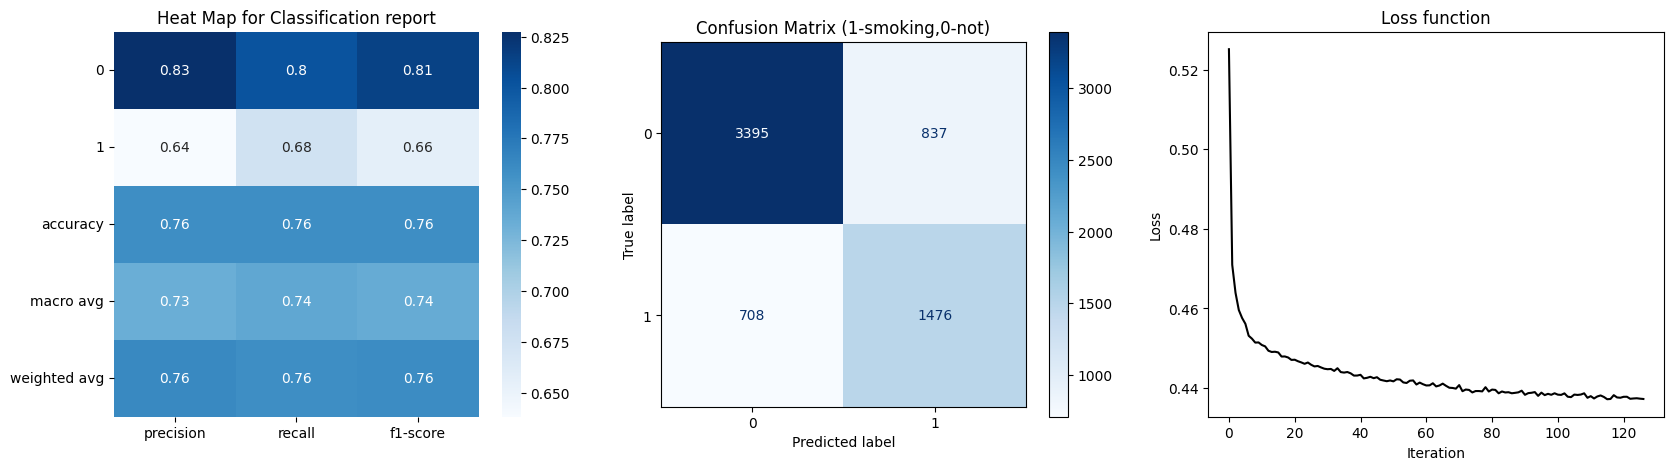

In [185]:
print(f'MLP-Final accuracy on train: {round(model.score(X_train_new_s, y_train_new)*100,3)} %')

pred_y = model.predict(X_valid_new_s)
NN_report = classification_report(y_val_new,pred_y, output_dict=True)
# Model Accuracy, how often is the classifier correct
print(f'MLP-Final accuracy on test: {round(accuracy_score(y_val_new,pred_y)*100,3)} %')

fig, ax = plt.subplots((1),(3),figsize = (20,5))
#plot 1
sns.heatmap(pd.DataFrame(NN_report).iloc[:-1, :].T, annot=True, cmap = "Blues", ax = ax[0])
ax[0].set_title('Heat Map for Classification report')
#plot 2
cm = confusion_matrix(y_val_new,pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues", ax=ax[1])
ax[1].set_title('Confusion Matrix (1-smoking,0-not)')
#plot 3
ax[2].plot(model.loss_curve_, color = "Black")
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("Loss")
ax[2].set_title('Loss function')

# K-Means Clustering

In [167]:
def visualizing_results(pca_result, label, centroids_pca):
    """ Visualizing the clusters
    :param pca_result: PCA applied data
    :param label: K Means labels
    :param centroids_pca: PCA format K Means centroids
    """
    # ------------------ Using Matplotlib for plotting-----------------------
    x = pca_result[:, 0]
    y = pca_result[:, 1]

    plt.scatter(x, y, c=label, alpha=0.9, s=12.5)  # plot different colors per cluster
    plt.title('K Means clusters')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, linewidths=1.5,
                color='red', edgecolors="black", lw=1.5)

    plt.show()


Explained variation per principal component: [0.56345013 0.24504734]
Cumulative variance explained by 2 principal components: 80.85%


4. Visualizing the data


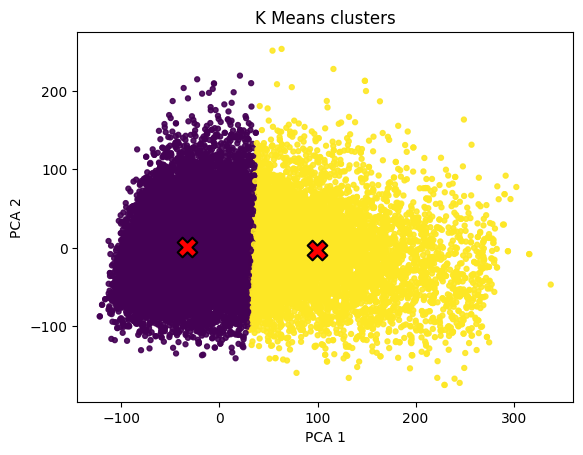

In [168]:

# Reducing the Dimensionality of the data to 2D
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(temp_df)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
# fitting KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(temp_df)
centroids = kmeans.cluster_centers_
centroids_pca = pca_2.transform(centroids)

print("\n\n4. Visualizing the data")
visualizing_results(pca_2_result[1:], kmeans.labels_[1:], centroids_pca)


In [171]:
temp_df_val = pd.concat([X_val, y_val], axis=1)

In [172]:
temp_df_val

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar,BMI,smoking
0,1,30.0,175.0,70.0,82.0,1.5,2.0,1.0,1.0,113.0,64.0,93.0,208.0,96.0,70.0,119.0,14.2,1.0,1.2,23.0,19.0,16,0,1,22.857143,0
1,1,40.0,155.0,65.0,82.5,1.0,0.7,1.0,1.0,97.0,70.0,104.0,182.0,47.0,69.0,103.0,16.7,1.0,0.8,14.0,15.0,24,1,1,27.055151,1
2,0,50.0,150.0,50.0,72.4,1.0,0.8,1.0,1.0,125.0,79.0,106.0,246.0,89.0,65.0,163.0,13.3,1.0,1.0,16.0,11.0,18,0,0,22.222222,0
3,1,40.0,180.0,70.0,84.0,0.7,1.0,1.0,1.0,118.0,68.0,107.0,183.0,54.0,80.0,92.0,13.2,1.0,1.2,25.0,22.0,29,1,1,21.604938,0
4,0,60.0,155.0,55.0,78.0,1.5,1.2,1.0,1.0,107.0,61.0,121.0,252.0,192.0,48.0,165.0,13.6,1.0,0.8,17.0,21.0,27,0,1,22.892820,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8015,1,30.0,165.0,85.0,95.0,1.2,1.5,1.0,1.0,122.0,88.0,102.0,219.0,177.0,55.0,129.0,15.4,1.0,0.8,30.0,37.0,60,0,1,31.221304,0
8016,1,40.0,170.0,70.0,82.2,1.5,0.9,1.0,1.0,128.0,84.0,98.0,151.0,190.0,49.0,64.0,16.2,1.0,1.0,32.0,30.0,89,0,1,24.221453,1
8017,1,20.0,170.0,65.0,83.8,0.2,0.3,1.0,1.0,120.0,80.0,78.0,147.0,78.0,63.0,68.0,17.4,1.0,0.9,21.0,16.0,21,0,0,22.491349,1
8018,1,65.0,160.0,55.0,74.0,0.7,0.5,1.0,1.0,145.0,82.0,99.0,178.0,59.0,72.0,93.0,13.8,1.0,0.9,33.0,16.0,14,0,1,21.484375,0


Explained variation per principal component: [0.56664447 0.2444666 ]
Cumulative variance explained by 2 principal components: 81.11%


4. Visualizing the data


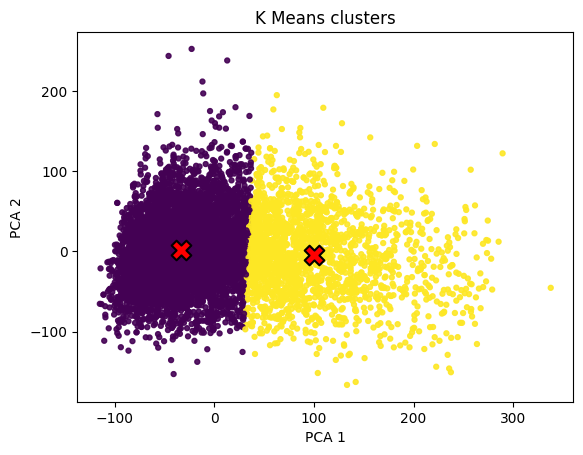

In [173]:
pd.set_option('display.max_columns', None)
# Reducing the Dimensionality of the data to 2D
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(temp_df_val)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
# fitting KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(temp_df_val)
centroids = kmeans.cluster_centers_
centroids_pca = pca_2.transform(centroids)

print("\n\n4. Visualizing the data")
visualizing_results(pca_2_result[1:], kmeans.labels_[1:], centroids_pca)


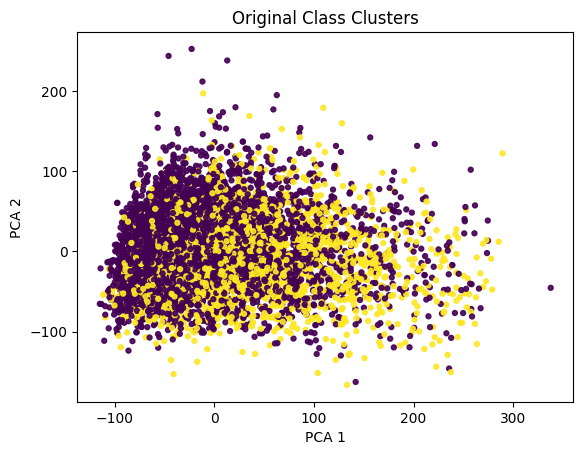

In [174]:
plot = temp_df_val['smoking']

x = pca_2_result[:, 0]
y = pca_2_result[:, 1]

plt.scatter(x, y, c=plot, alpha=0.9, s=12.5)  # plot different colors per cluster
plt.title('Original Class Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [175]:
k_means_results = pd.DataFrame(centroids)
k_means_results.columns = temp_df_val.columns
k_means_results
#  0 - Centroids for Non-Smokers
#  1 - Centroids for Smokers

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar,BMI,smoking
0,0.555888,44.015944,163.642252,63.283508,79.970487,1.011676,1.010563,1.024747,1.023584,119.858994,74.658695,95.900017,191.425677,88.943199,60.540608,113.097160,14.353230,1.075735,0.866235,22.911975,21.046670,25.763162,0.200299,0.534131,23.526261,0.287328
1,0.775888,44.317159,166.578289,71.228114,86.090595,1.027114,1.023162,1.030015,1.021511,124.630315,78.503252,102.700350,210.784392,218.365683,48.824912,118.964482,15.170435,1.077539,0.917459,25.627814,29.541271,42.587794,0.229615,0.571286,25.567358,0.495248


In [177]:
#Measuring the performance of the model
accuracy_score(plot.values, kmeans.labels_)

0.6584788029925187

In [198]:
temp_df_val.shape

(8020, 26)

In [179]:
# We will choose to train 8 models with the following K values:
# K = 2, 3, 4, 5, 6, 7, 8, 9
# We will use the Davies Bouldin Score to measure the performance of the model
# The Davies Bouldin Score is a measure of how well separated the clusters are
#Implementation using GridSearch:

params = {'n_clusters': [3,4,5,6,7,8,9,10]}
results = []
for i in params["n_clusters"]:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(temp_df)
    davies = davies_bouldin_score(temp_df, kmeans.labels_)
    silehouette = silhouette_score(temp_df, kmeans.labels_)
    calinski = calinski_harabasz_score(temp_df, kmeans.labels_)
    print("Davies Bouldin Score for K = {} is {}".format(i, davies))
    print("Silhouette Score for K = {} is {}".format(i, silehouette))
    print("Calinski Harabasz Score for K = {} is {}".format(i, calinski))
    results.append([i, davies, silehouette, calinski])




Davies Bouldin Score for K = 3 is 1.3388103748308626
Silhouette Score for K = 3 is 0.2437372075975793
Calinski Harabasz Score for K = 3 is 15956.473184539625
Davies Bouldin Score for K = 4 is 1.2976513968075036
Silhouette Score for K = 4 is 0.2346278170572996
Calinski Harabasz Score for K = 4 is 14130.467343451413
Davies Bouldin Score for K = 5 is 1.3090780443779682
Silhouette Score for K = 5 is 0.21265400533525974
Calinski Harabasz Score for K = 5 is 12751.428052540487
Davies Bouldin Score for K = 6 is 1.4412514290747653
Silhouette Score for K = 6 is 0.17693627049322924
Calinski Harabasz Score for K = 6 is 11451.264486997743
Davies Bouldin Score for K = 7 is 1.4063857760381484
Silhouette Score for K = 7 is 0.17598062146040436
Calinski Harabasz Score for K = 7 is 10569.420573687034
Davies Bouldin Score for K = 8 is 1.4330352975876717
Silhouette Score for K = 8 is 0.1674900704164932
Calinski Harabasz Score for K = 8 is 9800.53827091137
Davies Bouldin Score for K = 9 is 1.514366023172910

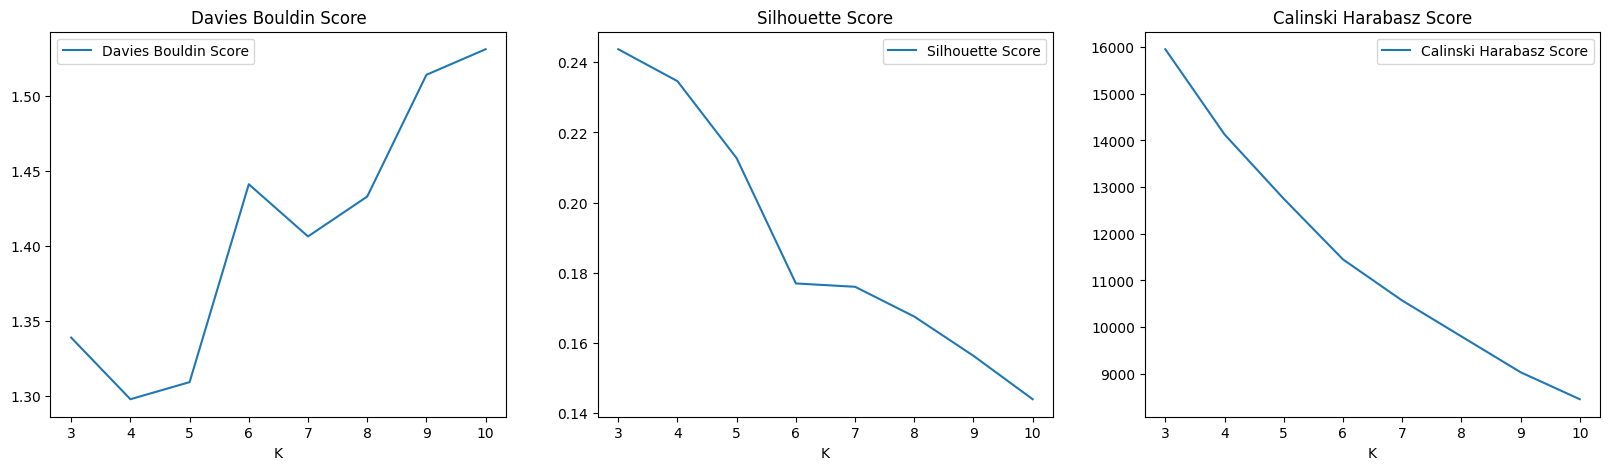

In [180]:
#Plotting the results
results = pd.DataFrame(results)
results.columns = ["K", "Davies Bouldin Score", "Silhouette Score", "Calinski Harabasz Score"]
#Line Plot Side by Side
fig, ax = plt.subplots(1,3, figsize=(20,5))
results.plot(x="K", y="Davies Bouldin Score", ax=ax[0], title="Davies Bouldin Score")
results.plot(x="K", y="Silhouette Score", ax=ax[1], title="Silhouette Score")
results.plot(x="K", y="Calinski Harabasz Score", ax=ax[2], title="Calinski Harabasz Score")
plt.show()




In [181]:
# Trying the same as before just with a diffrent Clustering Algorithm
# Agglomerative Clustering

# Fitting Agglomerative Clustering In a loop an saving the results
results = []
for i in params["n_clusters"]:
    agg = AgglomerativeClustering(n_clusters=i)
    agg.fit(temp_df)
    davies = davies_bouldin_score(temp_df, agg.labels_)
    silehouette = silhouette_score(temp_df, agg.labels_)
    calinski = calinski_harabasz_score(temp_df, agg.labels_)
    print("Davies Bouldin Score for K = {} is {}".format(i, davies))
    print("Silhouette Score for K = {} is {}".format(i, silehouette))
    print("Calinski Harabasz Score for K = {} is {}".format(i, calinski))
    results.append([i, davies, silehouette, calinski])


Davies Bouldin Score for K = 3 is 1.3409206073280913
Silhouette Score for K = 3 is 0.25755485130223976
Calinski Harabasz Score for K = 3 is 12492.580262713936
Davies Bouldin Score for K = 4 is 1.4638899365341889
Silhouette Score for K = 4 is 0.16489911117714118
Calinski Harabasz Score for K = 4 is 11568.421509523148
Davies Bouldin Score for K = 5 is 1.551184373838468
Silhouette Score for K = 5 is 0.1348584794345276
Calinski Harabasz Score for K = 5 is 10195.337141348047
Davies Bouldin Score for K = 6 is 1.6205041675327776
Silhouette Score for K = 6 is 0.1345520302988419
Calinski Harabasz Score for K = 6 is 9533.167288245813
Davies Bouldin Score for K = 7 is 1.6409814769591031
Silhouette Score for K = 7 is 0.10422100268976041
Calinski Harabasz Score for K = 7 is 8621.051295574664
Davies Bouldin Score for K = 8 is 1.712678849075701
Silhouette Score for K = 8 is 0.09833536962172866
Calinski Harabasz Score for K = 8 is 7911.256075982144
Davies Bouldin Score for K = 9 is 1.8029530186201133


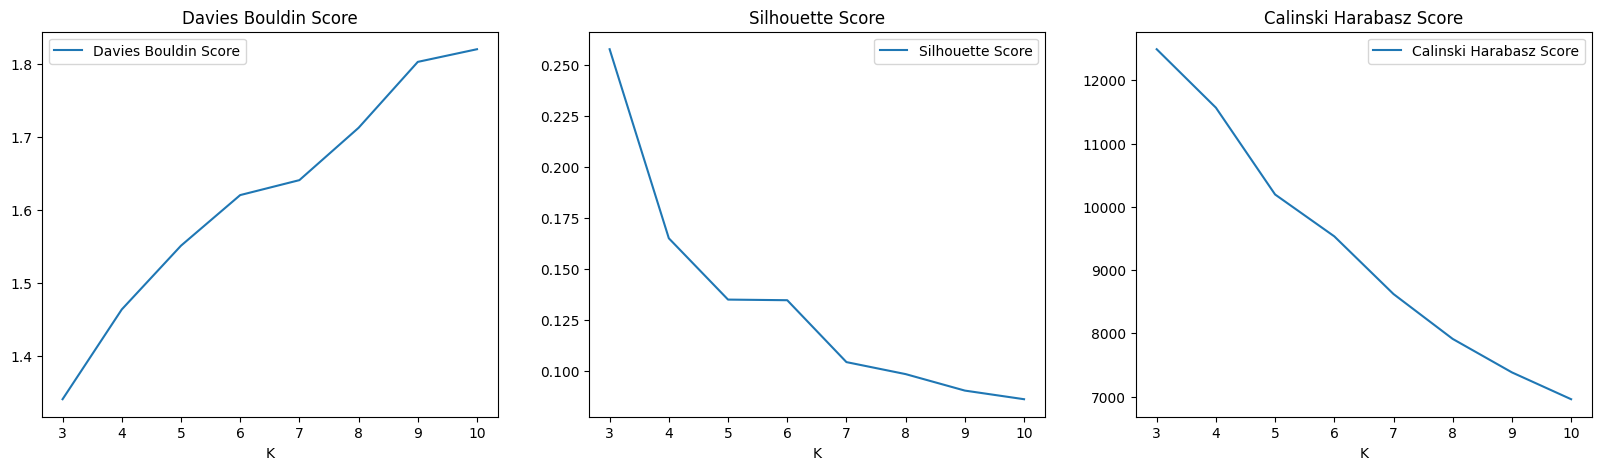

In [182]:
#Plotting the results
results = pd.DataFrame(results)
results.columns = ["K", "Davies Bouldin Score", "Silhouette Score", "Calinski Harabasz Score"]
#Line Plot Side by Side
fig, ax = plt.subplots(1,3, figsize=(20,5))
results.plot(x="K", y="Davies Bouldin Score", ax=ax[0], title="Davies Bouldin Score")
results.plot(x="K", y="Silhouette Score", ax=ax[1], title="Silhouette Score")
results.plot(x="K", y="Calinski Harabasz Score", ax=ax[2], title="Calinski Harabasz Score")
plt.show()

In [183]:
X_train_new

,gender,age,height(cm),weight(kg),waist(cm),triglyceride,HDL,hemoglobin,serum creatinine,ALT,Gtp,dental caries,tartar,BMI
16671,1,30.0,165.0,65.0,82.0,175.0,45.0,15.2,0.9,15.0,17,0,0,23.875115
3695,1,35.0,165.0,60.0,78.0,145.0,45.0,15.8,1.0,38.0,56,1,0,22.038567
3694,1,60.0,165.0,75.0,97.1,142.0,70.0,16.0,1.0,40.0,65,0,1,27.548209
14201,0,55.0,155.0,55.0,73.0,98.0,58.0,14.8,0.6,11.0,12,0,1,22.892820
29776,1,70.0,160.0,60.0,79.5,143.0,36.0,15.2,0.9,29.0,17,0,0,23.437500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17289,1,40.0,165.0,75.0,95.0,139.0,54.0,15.9,1.1,33.0,65,1,0,27.548209
5192,0,55.0,165.0,70.0,85.0,117.0,51.0,14.5,0.9,18.0,16,0,0,25.711662
12172,1,60.0,160.0,65.0,88.0,98.0,57.0,15.2,1.0,11.0,23,0,1,25.390625
235,1,45.0,170.0,85.0,95.0,177.0,40.0,13.9,1.1,42.0,26,1,1,29.411765


# Mission 4 - Unsupervised Learning

In [191]:



# Train a DT & NN model on the training data

nn = MLPClassifier(random_state=1,
                    hidden_layer_sizes=(10, 10,10,2),
                    max_iter=200,
                    activation='relu', 
                    verbose=False,
                    solver='adam',
                    alpha=0.000005,
                    learning_rate_init=0.005)

classifier_2.fit(X_train_new, y_train_new)
nn.fit(X_train_new_s, y_train_new)

# Make predictions on the test data using the DT & NN model
dt_predictions = classifier_2.predict(X_valid_new_s)
nn_predictions = nn.predict(X_valid_new_s)

# Compare the performance of the models using accuracy
dt_accuracy = accuracy_score(y_val_new, dt_predictions)
nn_accuracy = accuracy_score(y_val_new, nn_predictions)

print(f'Accuracy on Test:   \nDT accuracy: {dt_accuracy} \nNN accuracy: {nn_accuracy}')

Accuracy on Test:   
DT accuracy: 0.6935785536159601 
NN accuracy: 0.7591957605985037


In [192]:
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold', fontsize = 18)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

In [228]:
temp_df_val[wanted]

,gender,age,height(cm),weight(kg),waist(cm),triglyceride,HDL,hemoglobin,serum creatinine,ALT,Gtp,dental caries,tartar,BMI,smoking
0,1,30.0,175.0,70.0,82.0,96.0,70.0,14.2,1.2,19.0,16,0,1,22.857143,0
1,1,40.0,155.0,65.0,82.5,47.0,69.0,16.7,0.8,15.0,24,1,1,27.055151,1
2,0,50.0,150.0,50.0,72.4,89.0,65.0,13.3,1.0,11.0,18,0,0,22.222222,0
3,1,40.0,180.0,70.0,84.0,54.0,80.0,13.2,1.2,22.0,29,1,1,21.604938,0
4,0,60.0,155.0,55.0,78.0,192.0,48.0,13.6,0.8,21.0,27,0,1,22.892820,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8015,1,30.0,165.0,85.0,95.0,177.0,55.0,15.4,0.8,37.0,60,0,1,31.221304,0
8016,1,40.0,170.0,70.0,82.2,190.0,49.0,16.2,1.0,30.0,89,0,1,24.221453,1
8017,1,20.0,170.0,65.0,83.8,78.0,63.0,17.4,0.9,16.0,21,0,0,22.491349,1
8018,1,65.0,160.0,55.0,74.0,59.0,72.0,13.8,0.9,16.0,14,0,1,21.484375,0


In [238]:
# Reducing the Dimensionality of the data to 2D
X_val_2 = temp_df_val[wanted].drop(['smoking'], axis=1)
y_val_2 = temp_df_val[wanted]['smoking']
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(temp_df_val[wanted])
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
# fitting KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(temp_df_val)

Explained variation per principal component: [0.82068415 0.07027603]
Cumulative variance explained by 2 principal components: 89.10%


KMeans(n_clusters=2)

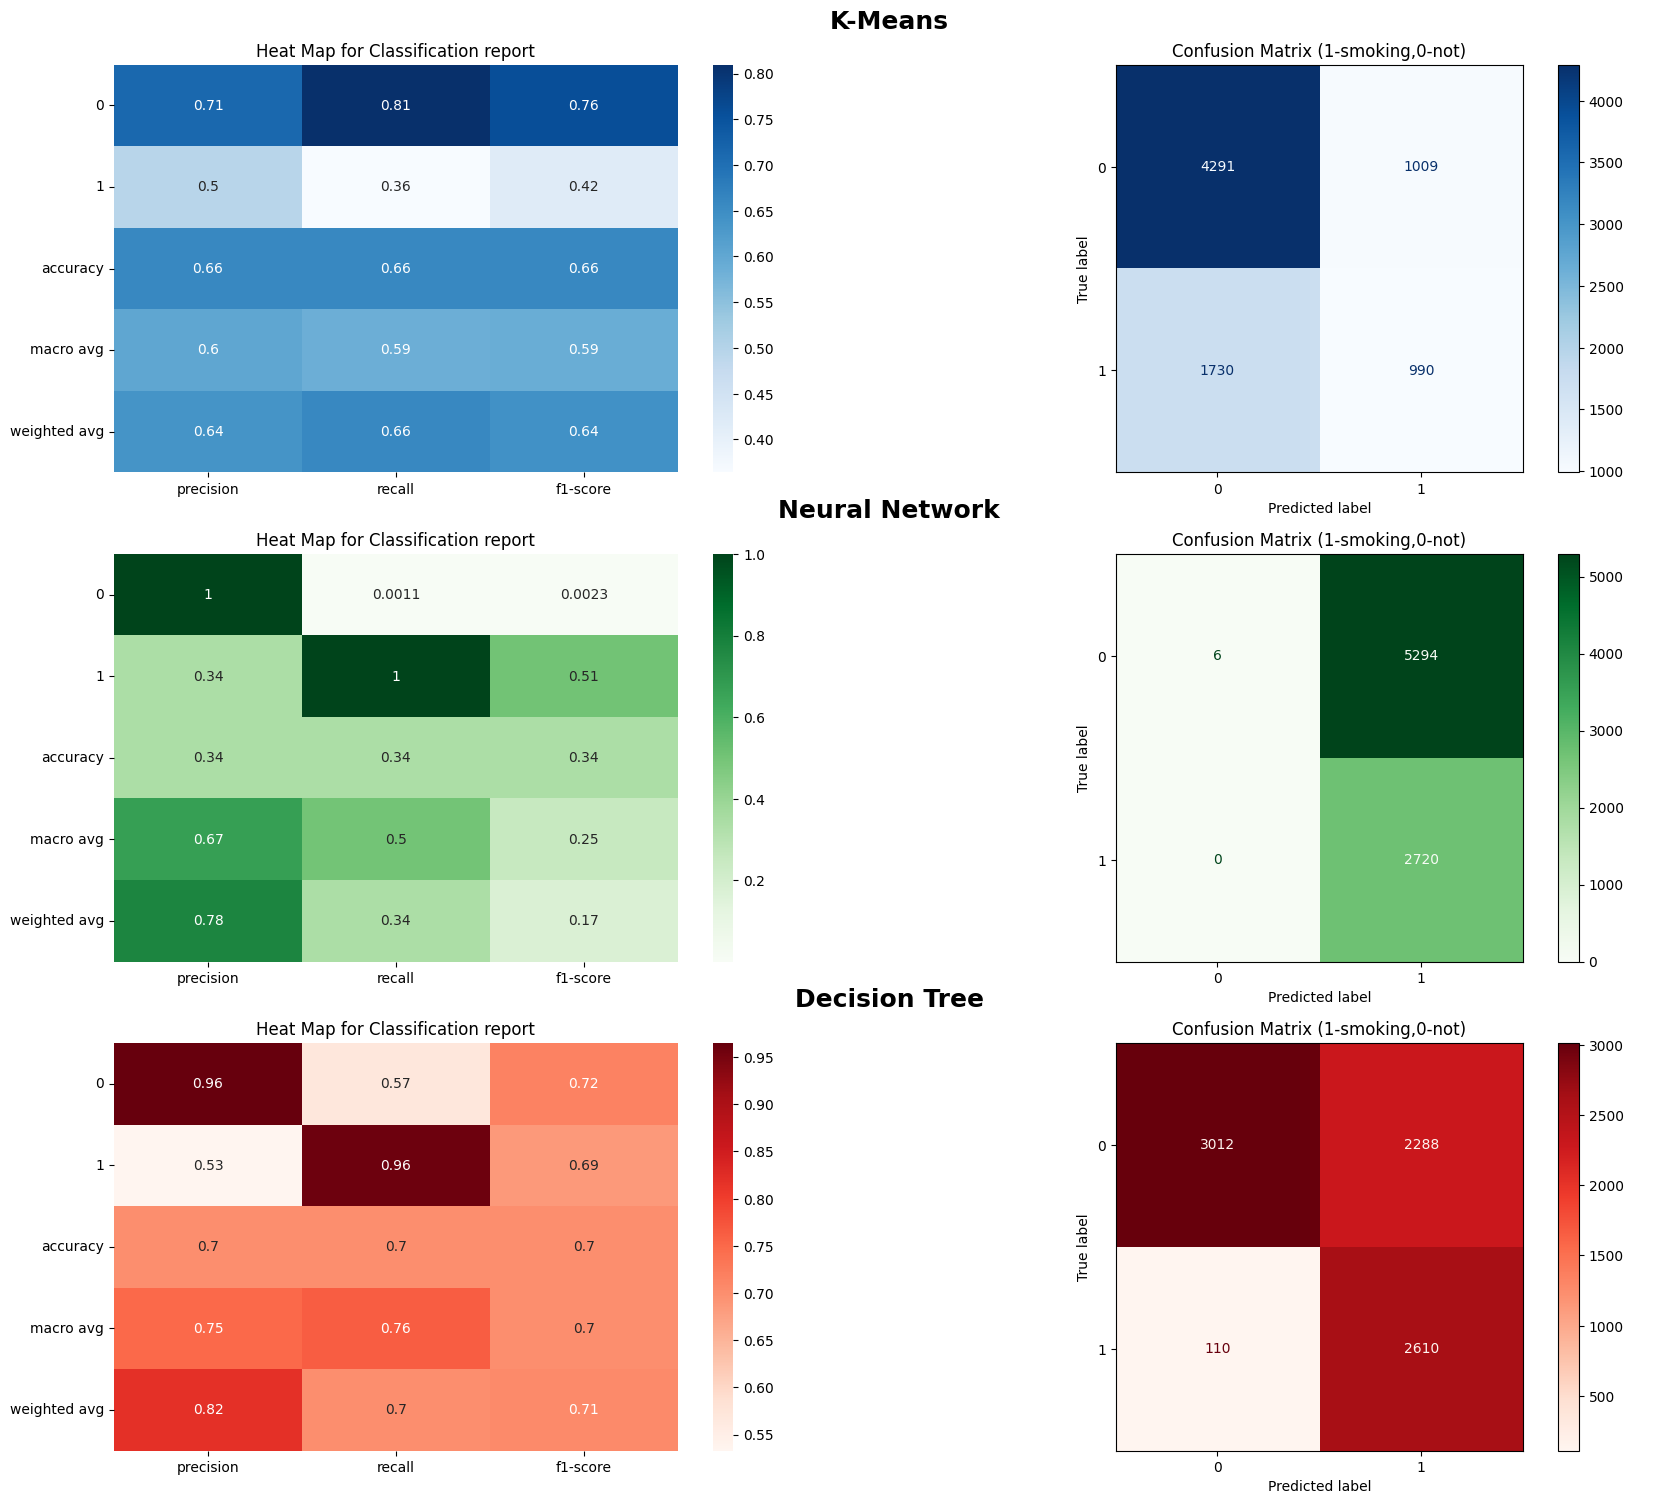

In [239]:
fig, ax = plt.subplots((3),(2),figsize = (20,18))
# Create grid
grid = plt.GridSpec(3, 3)
create_subtitle(fig, grid[0, ::], 'K-Means')
create_subtitle(fig, grid[1, ::], 'Neural Network')
create_subtitle(fig, grid[2, ::], 'Decision Tree')
fig.tight_layout()
fig.set_facecolor('w')

dict_model = {'model':[], 'report':[], 'pred':[], 'cm':[], 'acc':[],"f1_score": []}
for model in ([kmeans, nn, classifier_2]):
    if model is not kmeans:
        y_pred = model.predict(X_val_2)
    else:
        y_pred = model.labels_
  
        
    dict_model['model'].append(model)
    dict_model['report'].append(classification_report(y_val_2,y_pred, output_dict=True))
    dict_model['pred'].append(y_pred)
    dict_model['cm'].append(confusion_matrix(y_val_2,y_pred))
    dict_model['acc'].append(accuracy_score(y_val_2, y_pred))
    dict_model['f1_score'].append(f1_score(y_val_2, y_pred))

colors = ['Blues', 'Greens', 'Reds']
for i in range(3):
    #Heat map plot
    sns.heatmap(pd.DataFrame(dict_model['report'][i]).iloc[:-1, :].T, annot=True, cmap = colors[i], ax = ax[i][0])
    ax[i][0].set_title('Heat Map for Classification report')
    #Confusion Matrix plot
    cm = confusion_matrix(y_val_2,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=dict_model['cm'][i], display_labels=dict_model['model'][1].classes_)
    disp.plot(cmap=colors[i], ax=ax[i][1])
    ax[i][1].set_title('Confusion Matrix (1-smoking,0-not)')


In [240]:
dict_model['model'] = ['K-Means', 'Neural Network', 'Decision Tree']

In [241]:
dict_model["f1_score"]

[0.41958041958041953, 0.5068008198248556, 0.6852192176424258]

In [242]:
dict_model["acc"]

[0.6584788029925187, 0.3399002493765586, 0.7009975062344139]

In [243]:
res_df = pd.DataFrame({'Model': dict_model['model'], 'Accuracy': dict_model["acc"], 'F1 Score': dict_model["f1_score"]})

In [245]:
x = df.drop(['smoking'], axis=1)
y = df['smoking']
x_train_final, x_test_final, y_train_final, y_test_final = train_test_split(x, y, test_size=0.2, random_state=42)

In [285]:
wanted = [x for x in df_new.columns if x not in ['smoking']]
x_train_final = x_train_final[wanted]
x_test_final = x_test_final[wanted]
scaler = StandardScaler()
x_test_final = scaler.fit_transform(x_test_final)
x_train_final = scaler.fit_transform(x_train_final)



In [286]:
x_train_final.shape

(32076, 14)

In [287]:
# Train a neural network and a decision tree on the training set

nn = MLPClassifier(random_state=1,
                    hidden_layer_sizes=(10, 10,10,2),
                    max_iter=200,
                    activation='relu', 
                    verbose=False,
                    solver='adam',
                    alpha=0.000005,
                    learning_rate_init=0.005)

In [288]:
#fitting nn
nn.fit(x_train_final, y_train_final)

MLPClassifier(alpha=5e-06, hidden_layer_sizes=(10, 10, 10, 2),
              learning_rate_init=0.005, random_state=1)

In [289]:
x_train_final.shape

(32076, 14)

In [290]:
grid_search_2.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 20,
 'min_samples_leaf': 1000,
 'min_samples_split': 500,
 'splitter': 'best'}

In [291]:
# fitting Decision Tree
classifier_2 = DecisionTreeClassifier(criterion = 'gini', max_depth = 10,max_features=4, min_samples_leaf = 500, min_samples_split = 1000, splitter = 'best',class_weight='balanced')

In [292]:
classifier_2.fit(x_train_final, y_train_final)

DecisionTreeClassifier(class_weight='balanced', max_depth=10, max_features=4,
                       min_samples_leaf=500, min_samples_split=1000)

In [293]:
classifier_2.feature_importances_

array([9.06942447e-01, 1.10055542e-02, 4.82571945e-04, 0.00000000e+00,
       1.80883516e-03, 2.44890767e-02, 6.56223216e-03, 2.41193981e-03,
       2.70241959e-03, 6.57880461e-04, 2.79037572e-02, 6.05425927e-03,
       6.81133299e-03, 2.16769307e-03])

In [294]:
# Implement Voting Classifier and create ensemble model

dt = classifier_2
nn = nn
#Create ensemble model
ensemble = VotingClassifier(estimators=[('dt', dt), ('nn', nn)], voting='soft',weights=weights)
ensemble.fit(x_train_final, y_train_final)




VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=10,
                                                     max_features=4,
                                                     min_samples_leaf=500,
                                                     min_samples_split=1000)),
                             ('nn',
                              MLPClassifier(alpha=5e-06,
                                            hidden_layer_sizes=(10, 10, 10, 2),
                                            learning_rate_init=0.005,
                                            random_state=1))],
                 voting='soft', weights=tensor([0.6557, 0.3443]))

In [297]:
res = nn.predict(x_test_final)
accuracy_score(y_test_final, res)

0.7613466334164588

In [339]:
x_test_real = pd.read_csv('X_test.csv')

In [301]:
x_test_real.head()

,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar
0,40139,F,60.0,150.0,55.0,80.0,0.6,0.6,1.0,1.0,103.0,63.0,100.0,242.0,101.0,51.0,170.0,13.3,1,0.6,22.0,16.0,20,Y,0,N
1,35862,F,50.0,145.0,55.0,85.0,1.5,1.5,1.0,1.0,127.0,75.0,100.0,242.0,89.0,66.0,158.0,15.1,1,0.8,18.0,15.0,17,Y,0,Y
2,8918,F,60.0,155.0,65.0,85.2,1.0,0.9,1.0,1.0,110.0,70.0,88.0,214.0,124.0,60.0,129.0,14.1,1,0.8,17.0,15.0,22,Y,0,N
3,40190,M,55.0,180.0,85.0,99.0,0.7,0.7,1.0,1.0,108.0,74.0,119.0,110.0,155.0,37.0,42.0,13.8,1,1.0,21.0,24.0,35,Y,0,N
4,16914,F,60.0,150.0,55.0,79.0,0.4,0.4,1.0,1.0,143.0,77.0,101.0,176.0,156.0,58.0,89.0,13.5,1,0.7,42.0,22.0,28,Y,0,Y


In [340]:

l_1 = list(x_test_real["waist(cm)"])
misplaced_1 = [ind for ind,x in enumerate(l_1) if isfloat(x) == False]
# The Identified problematic rows

#Deleting rows with misplaced data ( Run only once)
try:
  x_test_real.drop([misplaced_1[0]],axis=0,inplace = True)
  print("Sample # ",misplaced_1[0] ,"was deleted")
except:
  print("Already deleted")

x_test_real["waist(cm)"] = x_test_real["waist(cm)"].astype(float)

#Identified as useless, because all of the samples are 1 and the only 12 
# different samples are misformatted
#Fixing oral values
x_test_real = x_test_real[(x_test_real["oral"] != "yes") & ((x_test_real["oral"] != "12"))]
x_test_real["oral"] = x_test_real["oral"].astype(object)
print(x_test_real["oral"].value_counts())

#Removing the row with the yes value and merging the float and the integers to one value 
x_test_real = x_test_real[x_test_real["Urine protein"] != "yes"]
x_test_real["Urine protein"] = x_test_real["Urine protein"].astype(float)
print(x_test_real["Urine protein"].value_counts())
print(pd.crosstab(x_test_real["Urine protein"],"Prior Probabity")/len(x_test_real))

x_test_real["weight(kg)"].astype(float)
x_test_real = x_test_real[x_test_real["waist(cm)"] != "ok"]
x_test_real["waist(cm)"] = x_test_real["waist(cm)"].astype(float)

#removing the null values
x_test_real.dropna(inplace = True)
#Removing all unreasonable values - removing the entire tuple if one of the values is unreasonable
# Fixing systolic values (there were negative values and values above 250)
x_test_real = x_test_real[(x_test_real["systolic"]> 0) & (x_test_real["systolic"]< 250)]
# Fixing fasting blood sugar values (there were values above 400 )
x_test_real = x_test_real[(x_test_real["fasting blood sugar"]> 0) & (x_test_real["fasting blood sugar"]< 200)]
# Fixing triglyceride values (there were values above 500 )
x_test_real = x_test_real[(x_test_real["triglyceride"]> 0) & (x_test_real["triglyceride"]< 500)]
# Fixing HDL cholesterol values (there were values above 300 )
x_test_real = x_test_real[(x_test_real["HDL"]> 10) & (x_test_real["HDL"]< 300)]
# Fixing LDL cholesterol values (there were values above 1800 )
x_test_real = x_test_real[(x_test_real["LDL"]> 0) & (x_test_real["LDL"]< 300)]
# Fixing serum creatinine values (there were values above 1.5 )
x_test_real = x_test_real[(x_test_real["serum creatinine"]> 0) & (x_test_real["serum creatinine"]< 1.5)]
# Fixing AST values (there were values above 50 )
x_test_real = x_test_real[(x_test_real["AST"]> 0) & (x_test_real["AST"]< 50)]
# Fixing ALT values (there were values above 100 )
x_test_real = x_test_real[(x_test_real["ALT"]> 0) & (x_test_real["ALT"]< 100)]
# Fixing Gtp values (there were values above 100 )
x_test_real = x_test_real[(x_test_real["Gtp"]> 0) & (x_test_real["Gtp"]< 100)]
#Deriving a new feature based on existing features
x_test_real["BMI"] = x_test_real["weight(kg)"]/((x_test_real["height(cm)"]/100)**2)

Already deleted
Y    11132
Name: oral, dtype: int64
1.0    10496
2.0      363
3.0      196
4.0       58
5.0       21
Name: Urine protein, dtype: int64
col_0          Prior Probabity
Urine protein                 
1.0                   0.942444
2.0                   0.032594
3.0                   0.017599
4.0                   0.005208
5.0                   0.001886


In [341]:

x_test_real = x_test_real.drop(['oral'],axis=1)
# dummies for gender
x_test_real['gender'].replace(['M', 'F'], [1,0], inplace=True)
# dummies for age
x_test_real['age'].replace(['Young', 'Middle', 'Old'], [2,1,0], inplace=True)
# dummies for height
x_test_real['height(cm)'].replace(['Middle', 'Tall', 'Short'], [2,1,0], inplace=True)
# dummies for weight
x_test_real['weight(kg)'].replace(['Underweight', 'Normal', 'Overweight'], [2,1,0], inplace=True)
# dummies for fasting blood sugar
x_test_real['fasting blood sugar'].replace(['Pre-Diabetes', 'Diabetes', 'Normal'], [2,1,0], inplace=True)
# dummies for tartar
x_test_real['tartar'].replace(['Y', 'N'], [1,0], inplace=True)

In [342]:
x_test_real = x_test_real.drop(['ID'],axis=1)

In [343]:
x_test_real = x_test_real[wanted]

In [344]:
x_test_real["gender"] = x_test_real["gender"][x_test_real["gender"] != "ok"]
x_test_real["tartar"] = x_test_real["tartar"][x_test_real["tartar"] != "yes"]
x_test_real["tartar"] = x_test_real["tartar"][x_test_real["tartar"] != "no"]


In [345]:
x_test_real.dropna(inplace = True)

In [346]:
x_test_real.head()

,gender,age,height(cm),weight(kg),waist(cm),triglyceride,HDL,hemoglobin,serum creatinine,ALT,Gtp,dental caries,tartar,BMI
0,0,60.0,150.0,55.0,80.0,101.0,51.0,13.3,0.6,16.0,20,0,0,24.444444
1,0,50.0,145.0,55.0,85.0,89.0,66.0,15.1,0.8,15.0,17,0,1,26.159334
2,0,60.0,155.0,65.0,85.2,124.0,60.0,14.1,0.8,15.0,22,0,0,27.055151
3,1,55.0,180.0,85.0,99.0,155.0,37.0,13.8,1.0,24.0,35,0,0,26.234568
4,0,60.0,150.0,55.0,79.0,156.0,58.0,13.5,0.7,22.0,28,0,1,24.444444


In [347]:
x_test_real["tartar"].value_counts()

1    5664
0    4373
Name: tartar, dtype: int64

In [348]:
scaler = StandardScaler()
x_test_real = scaler.fit_transform(x_test_real)
final_result = nn.predict(x_test_real)

In [349]:
final_result = pd.DataFrame(final_result)

In [351]:
final_result.columns = ["Target"]

In [ ]:
x_test_real = pd.read_csv("smoking_g25_25.csv")

In [352]:
final_result.to_csv("smoking_G25_ytest.csv")

0.7613466334164588

0.7297794117647058

0.627370417193426

0.6747110808973487

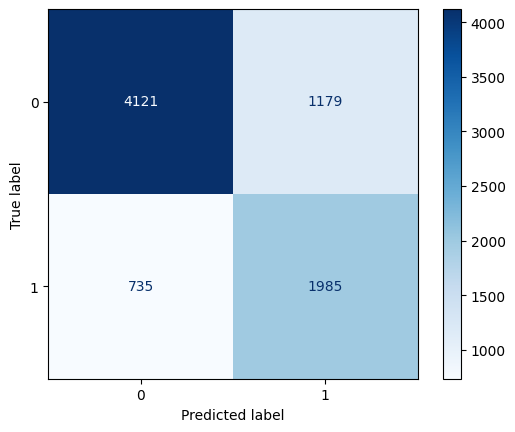

In [364]:
cm = confusion_matrix(y_test_final, res)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nn.classes_)
disp.plot(cmap="Blues")
display(accuracy_score(y_test_final, res))
display(recall_score(y_test_final, res))
display(precision_score(y_test_final, res))
display(f1_score(y_test_final, res))